In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from optuna.exceptions import ExperimentalWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ExperimentalWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt


# from pyspark.sql import SparkSession
from replay.utils.session_handler import get_spark_session, State

from replay.models import UCB, Wilson, RandomRec, LinUCB, ThompsonSampling
from replay.experimental.scenarios.movielens_wrapper.replay_offline import OBPOfflinePolicyLearner
from replay.experimental.scenarios.movielens_wrapper.dataset import MovielensBanditDataset
from replay.experimental.scenarios.movielens_wrapper.utils import get_est_rewards_by_reg, bandit_subset
from replay.utils.spark_utils import convert2spark

# from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust,
    SelfNormalizedInverseProbabilityWeighting,
    SelfNormalizedDoublyRobust,
    MarginalizedInverseProbabilityWeighting,
)

'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


In [4]:
# Vs_1 = np.load('Vs_1.npy', allow_pickle=True)
# CIs_1 = np.load('CIs_1.npy', allow_pickle=True)

# print('UCB')
# Vs_1[-1], CIs_1[-1]

In [5]:
# Vs_2 = np.load('Vs_2.npy', allow_pickle=True)
# CIs_2 = np.load('CIs_2.npy', allow_pickle=True)

# print('Lin-UCB')
# Vs_2[-1], CIs_2[-1]

In [6]:
# Vs_3 = np.load('Vs_3.npy', allow_pickle=True)
# CIs_3 = np.load('CIs_3.npy', allow_pickle=True)

# print('Random')
# Vs_3[-1], CIs_3[-1]

In [7]:
spark = State(get_spark_session()).session
spark.sparkContext.setLogLevel('ERROR')

24/09/29 14:04:10 WARN Utils: Your hostname, hdilab-hdilabALIEN05 resolves to a loopback address: 127.0.1.1; using 172.21.136.110 instead (on interface enp3s0)
24/09/29 14:04:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/29 14:04:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/29 14:04:11 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


Lets define OpenBanditDataset class with random policy. For the purpose of demonstration we won't use the whole dataset but only subset of size 10000.

In [9]:
from rs_datasets import MovieLens

data = MovieLens("1m")
data.info()

ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


Оставим только 300 самых популярных айтемов

In [10]:
logs = data.ratings
logs['cnt'] = 1
logs = logs[['item_id', 'cnt']].groupby(by=["item_id"]).sum()
logs = logs.sort_values(by=['cnt'], ascending=False).reset_index()
popular_items = logs.iloc[:2000]['item_id'].tolist()
# popular_items = logs['item_id'].tolist()

In [11]:
data.ratings = data.ratings[data.ratings['item_id'].isin(popular_items)]
print('размер датасета логов после выброса непопулярных айтемов:', data.ratings.shape)

размер датасета логов после выброса непопулярных айтемов: (940319, 5)


Оставим информацию только о фичах юзеров и айтемов которые остались в логах

In [12]:
data.items = data.items[data.items['item_id'].isin(popular_items)]
users = set(data.ratings['user_id'].tolist())
data.users = data.users[data.users['user_id'].isin(users)]
data.users.shape, data.items.shape

((6040, 5), (2000, 3))

In [13]:
len(data.items['item_id'].unique()), len(data.ratings['item_id'].unique())

(2000, 2000)

In [14]:
dataset = MovielensBanditDataset(data)

29-Sep-24 14:04:35, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


29-Sep-24 14:04:41, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
29-Sep-24 14:04:42, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


loading pretrained model


In [15]:
import psutil
psutil.virtual_memory().percent

17.3

In [16]:
bandit_feedback_train, bandit_feedback_test = dataset.obtain_batch_bandit_feedback(test_size=0.3, is_timeseries_split=True)

print(bandit_feedback_train["n_rounds"])
print(bandit_feedback_test["n_rounds"])

658220
282099


In [17]:
psutil.virtual_memory().percent

18.5

In [18]:
train_log = bandit_feedback_train['log'].toPandas()
train_items = train_log['item_idx'].tolist()
train_pscores = train_log['pscore'].tolist()

test_log = bandit_feedback_test['log'].toPandas()
test_items = test_log['item_idx'].tolist()
test_pscores = test_log['pscore'].tolist()

In [19]:
item2pscore = np.zeros(dataset.n_actions)
for i in range(train_log.shape[0]):
    item2pscore[train_items[i]] = train_pscores[i]
    
for i in range(test_log.shape[0]):
    item2pscore[test_items[i]] = test_pscores[i]

In [20]:
bandit_feedback_train.keys()

dict_keys(['log', 'item_features', 'user_features', 'n_rounds', 'n_actions', 'action', 'position', 'reward', 'pscore', 'context', 'action_context'])

The keys of the dictionary are as follows.
- n_rounds: number of rounds, data size of the logged bandit data;
- n_actions: number of actions $|\mathcal{A}|$;
- action: action variables sampled by the behavior policy;
- position: positions where actions are recommended, there are three positions in the ZOZOTOWN rec interface;
- reward: binary reward variables, click indicators;
- pscore: action choice probabilities by the behavior policy, propensity scores;
- context: context vectors such as user-related features and user-item affinity scores;
- action_context: item-related context vectors

In [21]:
#Define replay model
# model_1 = UCB(exploration_coef = 0.01, sample = True, seed = 123)
model_2 = LinUCB(eps = -10.0, alpha = 1.0, regr_type = 'disjoint')
# model_3 = RandomRec(seed=42)
# model_4 = ThompsonSampling(sample = True, seed = 123)

#Define learner which connects OBP data format with replay
# learner_1 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
#                                     replay_model=model_1) #len_list is the number of predicted items per user
learner_2 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_2) #len_list is the number of predicted items per user
# learner_3 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
#                                     replay_model=model_3)
# learner_4 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
#                                     replay_model=model_4)

**RePlayOfflinePolicyLearner** has the following methods
- *fit(action, reward, timestamp, context, action_context)*;
- *predict(n_rounds, context)* (context can be None thus n_rounds is **required**);
- *optimize(bandit_feedback, val_size, param_borders, criterion, budget, new_study)*

In [23]:
bandit_feedback_train['log'].toPandas()

,user_idx,item_idx,relevance,timestamp,cnt,pscore
0,4,9,1,2000-11-22 03:48:31,1,0.002757
1,4,788,1,2000-11-22 03:48:31,1,0.000443
2,4,1248,1,2000-11-22 03:47:32,1,0.000277
3,4,1072,1,2000-11-22 03:47:32,1,0.000314
4,4,368,0,2000-11-22 03:48:31,1,0.000768
...,...,...,...,...,...,...
658215,794,858,0,2000-04-26 06:35:41,1,0.000406
658216,794,123,1,2000-04-26 03:21:27,1,0.001436
658217,794,650,1,2000-04-26 03:19:06,1,0.000550
658218,794,945,1,2000-04-26 06:20:48,1,0.000412


In [24]:
#Fit replay model inside our learner
# learner_1.fit(bandit_feedback_train)
learner_2.fit(bandit_feedback_train)
# learner_3.fit(bandit_feedback_train)
# learner_4.fit(bandit_feedback_train)

# Off-policy evaluation

In [25]:
psutil.virtual_memory().percent

19.8

In [24]:
estimated_rewards_by_reg_model = get_est_rewards_by_reg(bandit_feedback_train['n_actions'],
                                                        dataset.len_list,
                                                        bandit_feedback_train,
                                                        bandit_feedback_test)

# np.save('estimated_rewards_by_reg_model_n.npy', estimated_rewards_by_reg_model)
estimated_rewards_by_reg_model = np.load('estimated_rewards_by_reg_model_n.npy')

In [25]:
psutil.virtual_memory().percent

40.8

When we get distribution over actions - we can run any evaluation procedure from the OBP. Here we use three estimators
- *IPW*: Average rewards with importance weights
- *DM*: Average predicted rewards using the classifier
- *DR*: Combination of the above methods with zero bias and lower variance

Also, we can construct confidence intervals for each of these methods.

In [26]:
def get_dist(learner):
    all_action_dist = np.zeros((bandit_feedback_test["n_rounds"], bandit_feedback_test["n_actions"], 1))
    if isinstance(learner.replay_model, (LinUCB)):
        log_distinct = bandit_feedback_test['log'].toPandas().drop_duplicates(subset=["user_idx"], keep='first')
        users_all = bandit_feedback_test['log'].toPandas()['user_idx'].tolist()
        batch_size = 10
        num_batchs = log_distinct.shape[0] // batch_size
        for i in tqdm(range(num_batchs+1)):
            j = min((i+1)*batch_size, bandit_feedback_test["n_rounds"])
            if j == i*batch_size:
                break
            log_subset = log_distinct.iloc[i*batch_size: j]
            n_rounds = log_subset.shape[0]
            
            action_dist = learner.predict(n_rounds, convert2spark(log_subset).select('user_idx'))

            users_distinct = log_subset['user_idx'].tolist()

            user2ind = {}
            for i in range(n_rounds):
                user2ind[users_distinct[i]] = i

            for i in range(bandit_feedback_test["n_rounds"]):
                if users_all[i] in users_distinct:
                    all_action_dist[i] = action_dist[user2ind[users_all[i]]]

    else:
        batch_size = 300
        num_batchs = bandit_feedback_test["n_rounds"] // batch_size
        for i in tqdm(range(num_batchs+1)):
            j = min((i+1)*batch_size, bandit_feedback_test["n_rounds"])
            if j == i*batch_size:
                break
            bandit_feedback_subset = bandit_subset([i*batch_size, j], bandit_feedback_test) #The first parameter is a slice of subset [a, b]
            action_dist = learner.predict(bandit_feedback_subset["n_rounds"], bandit_feedback_subset["log"].select('user_idx'))
            all_action_dist[i*batch_size:j] = action_dist
    return all_action_dist

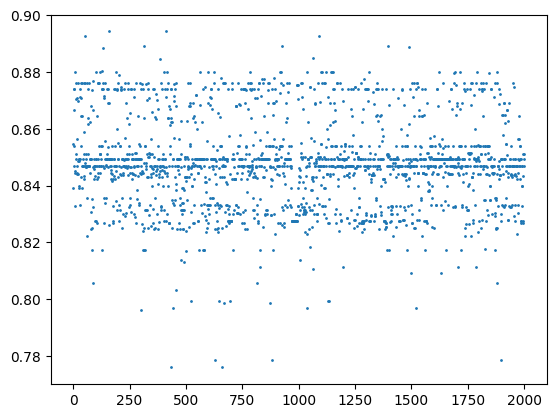

In [27]:
plt.scatter(np.arange(len(estimated_rewards_by_reg_model[0][:, 0])), estimated_rewards_by_reg_model[0][:, 0], s = 1)
plt.show()

In [28]:
#Predict distribution over actions: shape (n_rounds, n_actions)
import time
import warnings
warnings.filterwarnings("ignore")

# learner_action_dist_1 = get_dist(learner_1)
# np.save('learner_action_dist_1.npy', learner_action_dist_1)

# learner_action_dist_2 = get_dist(learner_2)

# np.save('learner_action_dist_2_n.npy', learner_action_dist_2)
learner_action_dist_2 = np.load('learner_action_dist_2_n.npy')

# learner_action_dist_3 = get_dist(learner_3)
# np.save('learner_action_dist_3.npy', learner_action_dist_3)

# learner_action_dist_4 = get_dist(learner_4)


# learner_action_dist_1 = np.load('learner_action_dist_1.npy')
# learner_action_dist_2 = np.load('learner_action_dist_2.npy')
# learner_action_dist_3 = np.load('learner_action_dist_3.npy')

In [29]:
psutil.virtual_memory().percent

54.2

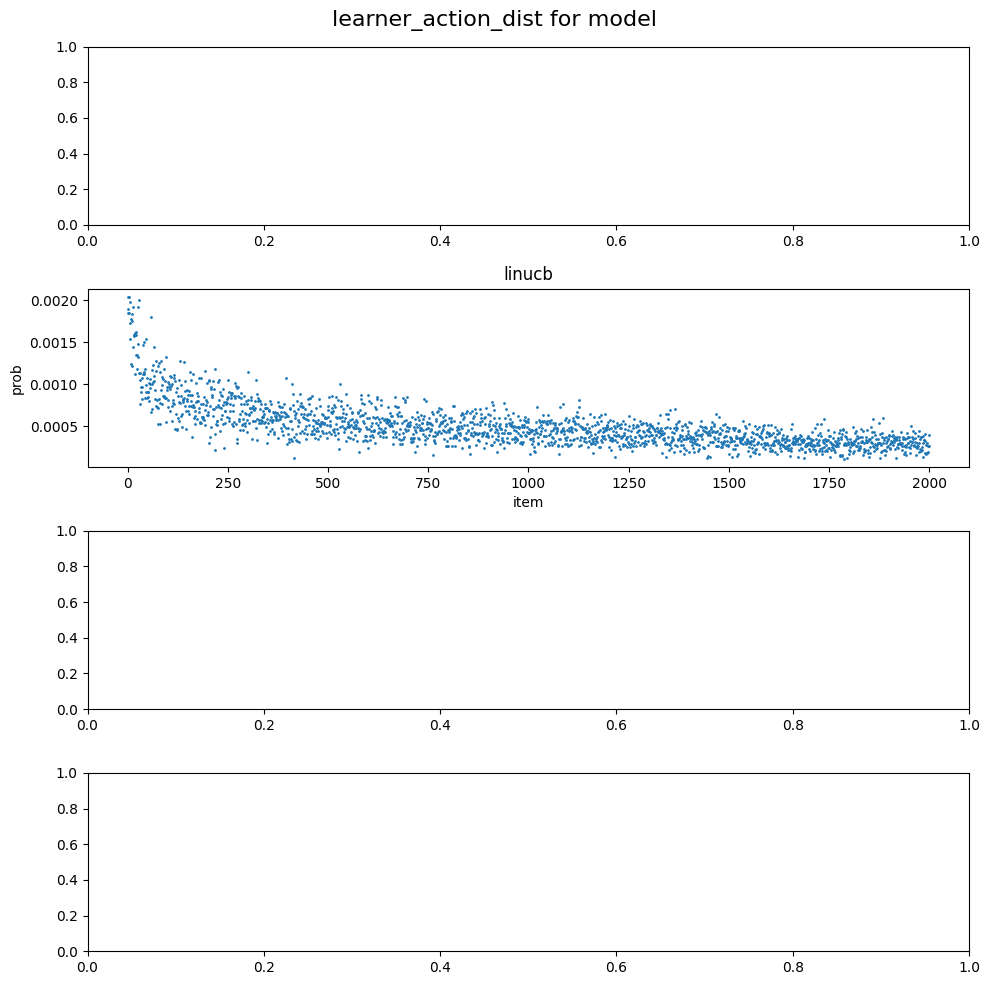

In [30]:
fig, ax = plt.subplots(4, figsize=(10, 10))

# ax[0].set_title('ucb')
# ax[0].set_xlabel('item')
# ax[0].set_ylabel('prob')

# ax[0].scatter(np.arange(len(learner_action_dist_1[0][:, 0])), learner_action_dist_1[0][:, 0], s = 1)


ax[1].set_title('linucb')
ax[1].set_xlabel('item')
ax[1].set_ylabel('prob')

ax[1].scatter(np.arange(len(learner_action_dist_2[0][:, 0])), learner_action_dist_2[0][:, 0], s = 1)


# ax[2].set_title('random')
# ax[2].set_xlabel('item')
# ax[2].set_ylabel('prob')

# ax[2].scatter(np.arange(len(learner_action_dist_3[0][:, 0])), learner_action_dist_3[0][:, 0], s = 1)


# ax[3].set_title('ts')
# ax[3].set_xlabel('item')
# ax[3].set_ylabel('prob')

# ax[3].scatter(np.arange(len(learner_action_dist_4[0][:, 0])), learner_action_dist_4[0][:, 0], s = 1)


fig.suptitle("learner_action_dist for model", fontsize=16)
plt.tight_layout()

In [31]:
actions = bandit_feedback_test['action']
pscores = bandit_feedback_test['pscore']
rewards = bandit_feedback_test['reward'][actions]

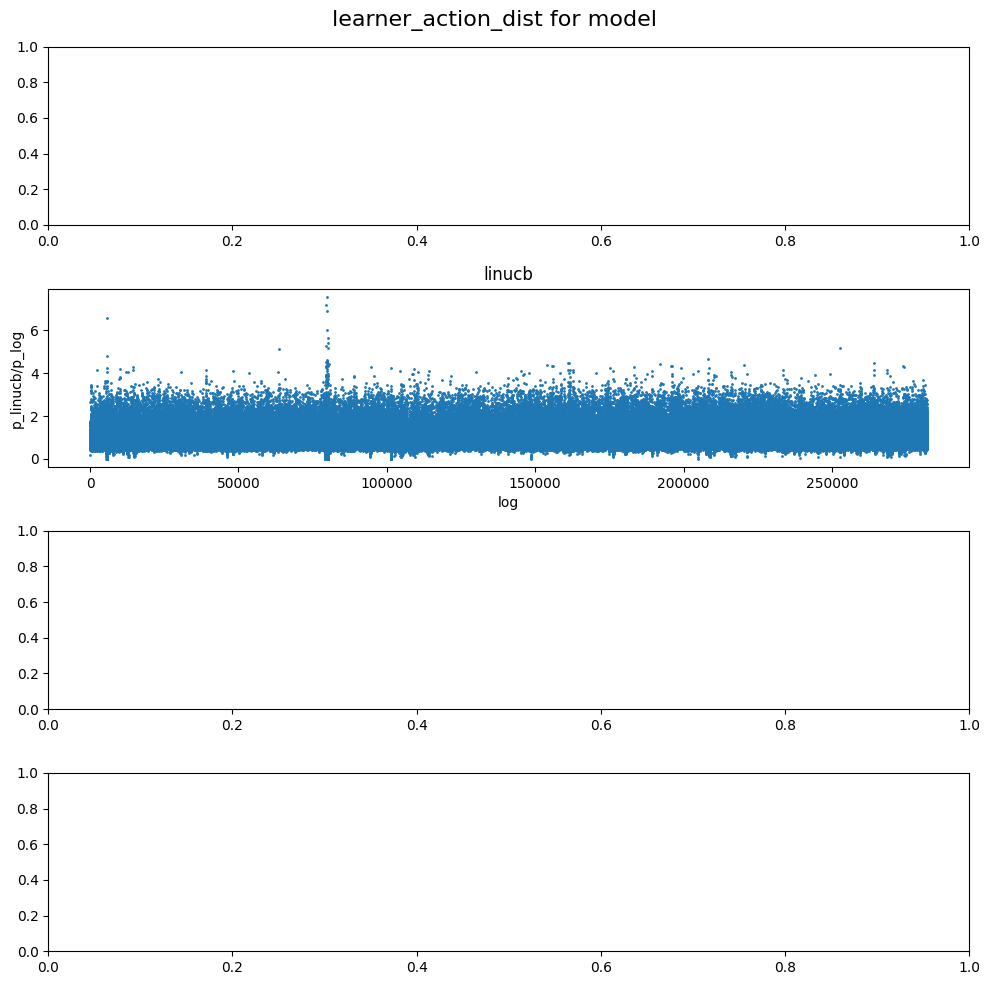

In [32]:
fig, ax = plt.subplots(4, figsize=(10, 10))

# ax[0].set_title('ucb')
# ax[0].set_xlabel('log')
# ax[0].set_ylabel('p_ucb/p_log')

# ax[0].scatter(np.arange(actions.size), learner_action_dist_1[np.arange(actions.size), actions, 0]/pscores, s = 1)
# ips1 = (rewards * learner_action_dist_1[np.arange(actions.size), actions, 0]/pscores).mean()

ax[1].set_title('linucb')
ax[1].set_xlabel('log')
ax[1].set_ylabel('p_linucb/p_log')

ax[1].scatter(np.arange(actions.size), learner_action_dist_2[np.arange(actions.size), actions, 0]/pscores, s = 1)
ips2 = (rewards * learner_action_dist_2[np.arange(actions.size), actions, 0]/pscores).mean()


# ax[2].set_title('random')
# ax[2].set_xlabel('log')
# ax[2].set_ylabel('p_random/p_log')

# ax[2].scatter(np.arange(actions.size), learner_action_dist_3[np.arange(actions.size), actions, 0]/pscores, s = 1)
# ips3 = (rewards * learner_action_dist_3[np.arange(actions.size), actions, 0]/pscores).mean()


# ax[3].set_title('ts')
# ax[3].set_xlabel('log')
# ax[3].set_ylabel('p_random/p_log')

# ax[3].scatter(np.arange(actions.size), learner_action_dist_4[np.arange(actions.size), actions, 0]/pscores, s = 1)
# ips4 = (rewards * learner_action_dist_4[np.arange(actions.size), actions, 0]/pscores).mean()



fig.suptitle("learner_action_dist for model", fontsize=16)
plt.tight_layout()


# print('ips ucb:', ips1)
# print('ips linucb:', ips2)
# print('ips random:', ips3)
# print('ips ts:', ips4)

In [33]:
bandit_feedback_test["n_rounds"]

282099

In [34]:
psutil.virtual_memory().percent

54.3

In [35]:
bandit_feedback_test["n_rounds"]

282099

In [37]:
def run_exp(learner_action_dist):
    Vs = []
    CIs = []

    # for n_size in [50000, 100000, 150000, 200000, 250000, 300000]:
    for n_size in [50000, 100000, 150000, 200000, 250000, bandit_feedback_test["n_rounds"]]:
    # for n_size in [20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000, bandit_feedback_test["n_rounds"]]:
    # for n_size in [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, bandit_feedback_test["n_rounds"]]:
    
        print(1, n_size, psutil.virtual_memory().percent)
        start = time.time()
        bandit_feedback_subset = bandit_subset([0, n_size], bandit_feedback_test) #The first parameter is a slice of subset [a, b]
        print(2, n_size, psutil.virtual_memory().percent)

        ope = OffPolicyEvaluation(
            bandit_feedback=bandit_feedback_subset,
            ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), SelfNormalizedDoublyRobust(),
                            SelfNormalizedInverseProbabilityWeighting(),]
        )
        print(3, n_size, psutil.virtual_memory().percent)

        estimated_rewards_by_reg_model_subset = estimated_rewards_by_reg_model[0: n_size, :]
        print(4, n_size, psutil.virtual_memory().percent)
        
        action_dist = learner_action_dist[:n_size, :]
        print(5, n_size, psutil.virtual_memory().percent)
        estimated_policy_value = ope.estimate_policy_values(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset,
        )
        print(6, n_size, psutil.virtual_memory().percent)

        estimated_ci = ope.estimate_intervals(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset,
            n_bootstrap_samples=10000,
            random_state=12345,)
        print(7, n_size, psutil.virtual_memory().percent)
        end = time.time()
        print("n_size =", n_size, "time: ", end-start)
        Vs.append(estimated_policy_value)
        CIs.append(estimated_ci)
        print(8, n_size, psutil.virtual_memory().percent)
    return(Vs, CIs)

In [43]:
# Vs_1, CIs_1 = run_exp(learner_action_dist_1)


# np.save('Vs_1.npy', Vs_1)
# np.save('CIs_1.npy', CIs_1)

# Vs_1 = np.load('Vs_1.npy', allow_pickle=True)
# CIs_1 = np.load('CIs_1.npy', allow_pickle=True)

In [38]:
# Vs_2, CIs_2 = run_exp(learner_action_dist_2)

# np.save('Vs_2_n.npy', Vs_2)
# np.save('CIs_2_n.npy', CIs_2)

# Vs_2 = np.load('Vs_2.npy', allow_pickle=True)
# CIs_2 = np.load('CIs_2.npy', allow_pickle=True)

1 50000 54.3
2 50000 54.3
3 50000 54.3
4 50000 54.3
5 50000 54.3
6 50000 54.3
7 50000 54.3
n_size = 50000 time:  16.58417773246765
8 50000 54.3
1 100000 54.3
2 100000 54.3
3 100000 54.3
4 100000 54.3
5 100000 54.3
6 100000 54.3
7 100000 54.3
n_size = 100000 time:  32.5223605632782
8 100000 54.3
1 150000 54.3
2 150000 54.5
3 150000 54.5
4 150000 54.5
5 150000 54.5
6 150000 54.4
7 150000 54.5
n_size = 150000 time:  77.52101755142212
8 150000 54.5
1 200000 54.5
2 200000 54.8
3 200000 54.8
4 200000 54.8
5 200000 54.8
6 200000 54.9
7 200000 54.9
n_size = 200000 time:  65.27291774749756
8 200000 54.9
1 250000 54.9
2 250000 55.5
3 250000 55.5
4 250000 55.5
5 250000 55.5
6 250000 55.4
7 250000 55.3
n_size = 250000 time:  58.104196310043335
8 250000 55.3
1 282099 55.3
2 282099 56.0
3 282099 56.0
4 282099 56.0
5 282099 56.0
6 282099 51.4
7 282099 50.6
n_size = 282099 time:  164.6009955406189
8 282099 50.6


In [46]:
# Vs_3, CIs_3 = run_exp(learner_action_dist_3)

# np.save('Vs_3.npy', Vs_3)
# np.save('CIs_3.npy', CIs_3)

# Vs_3 = np.load('Vs_3.npy', allow_pickle=True)
# CIs_3 = np.load('CIs_3.npy', allow_pickle=True)

In [36]:
# Vs_4, CIs_4 = run_exp(learner_action_dist_4)

# np.save('Vs_4.npy', Vs_4)
# np.save('CIs_4.npy', CIs_4)

In [39]:
def plot_disjoint_res(Vs, CIs, model): 
    fig, ax = plt.subplots(4, figsize=(10, 10))

    # x = [5000, 10000, 15000, 20000, 25000, 30000]
    x = [50000, 100000, 150000, 200000, 250000, bandit_feedback_test["n_rounds"]]
    # x = [20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000, bandit_feedback_test["n_rounds"]]
    # x = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, bandit_feedback_test["n_rounds"]]
    colors = ['b', 'r', 'g', 'y', 'k']
    i = 0
    for name in ['ipw', 'dm', 'sndr', 'snipw']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax[i].plot(x, y_est, '-', label=name, color = colors[i])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[i])
        i=i+1
    fig.suptitle("OPE for " + model, fontsize=16)
    fig.legend()
    plt.tight_layout()

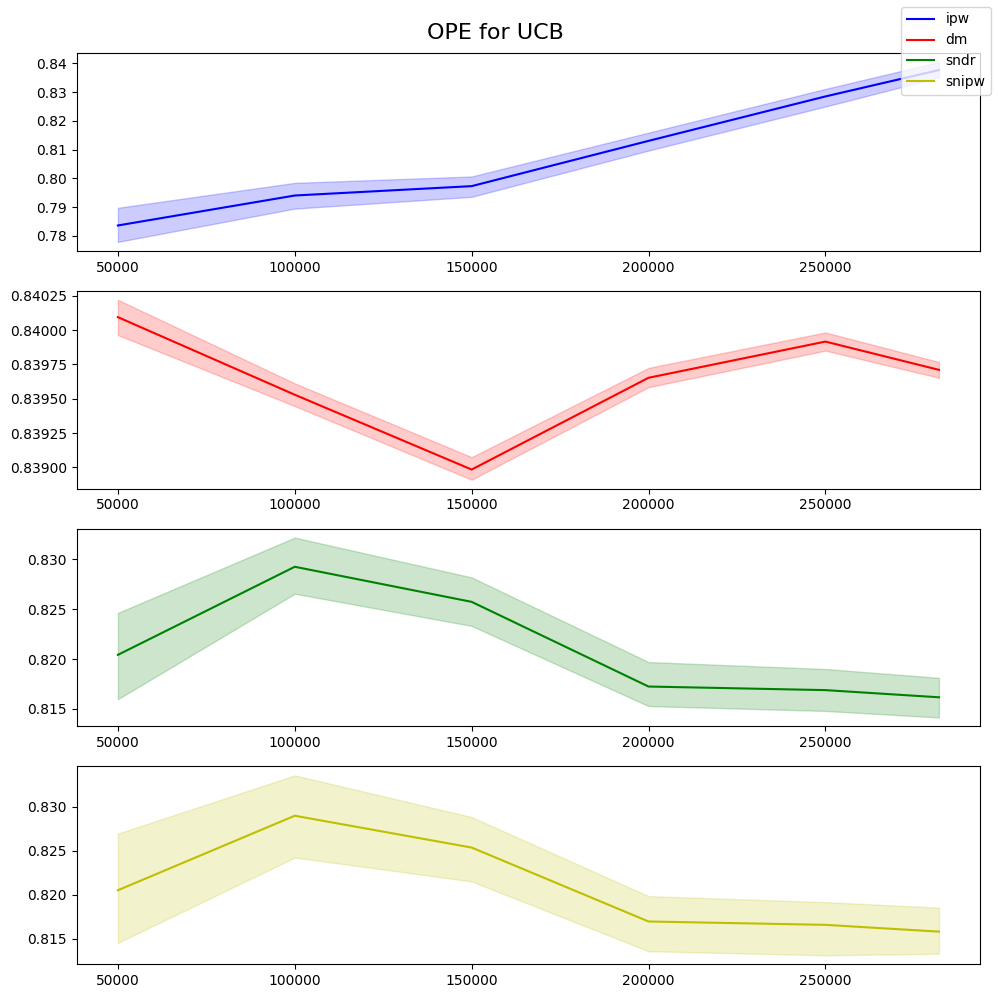

In [48]:
plot_disjoint_res(Vs_1, CIs_1, 'UCB')

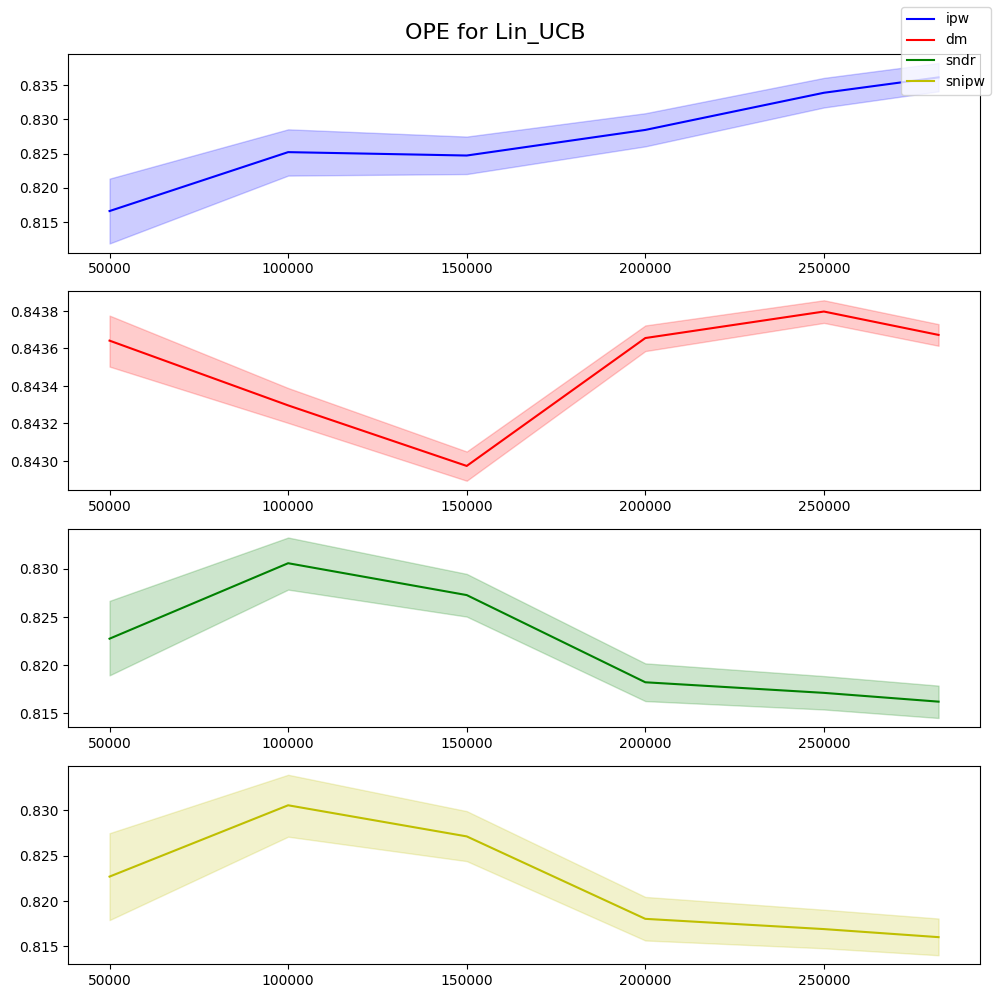

In [40]:
plot_disjoint_res(Vs_2, CIs_2, 'Lin_UCB')

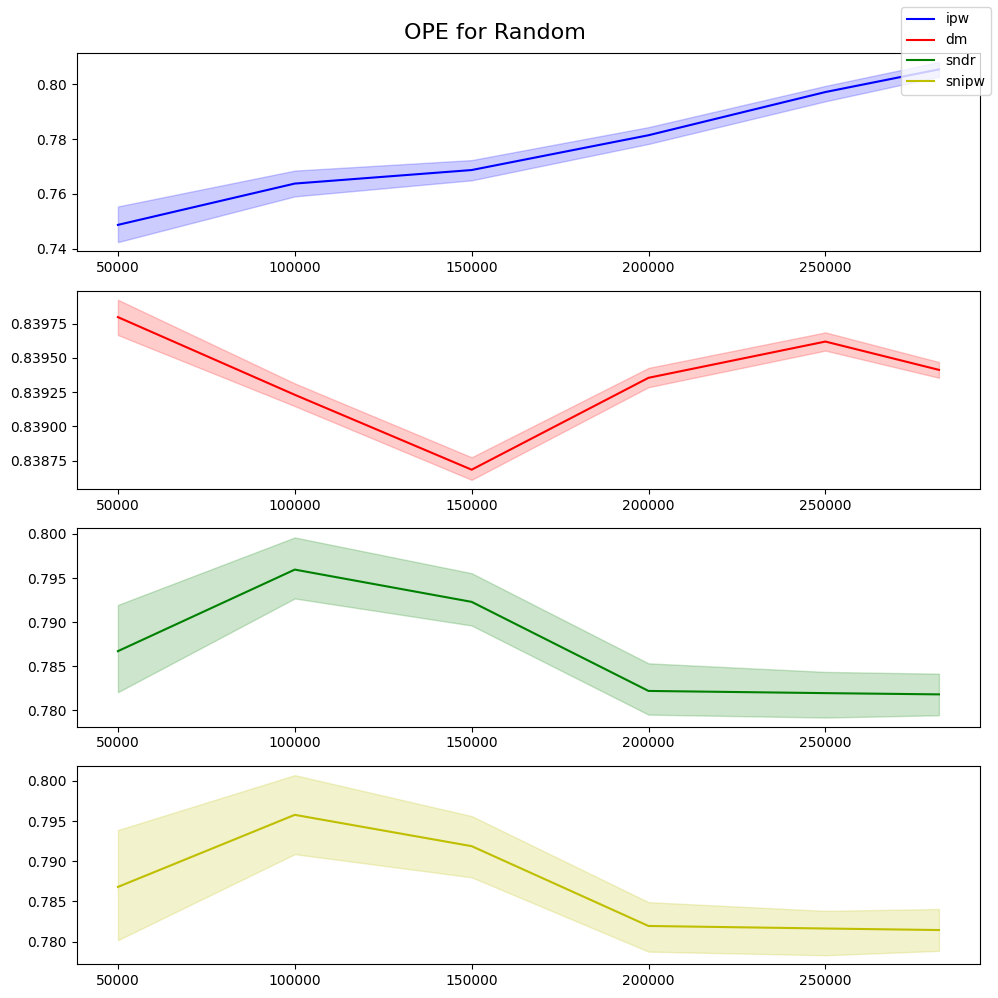

In [50]:
plot_disjoint_res(Vs_3, CIs_3, 'Random')

In [34]:
# plot_disjoint_res(Vs_4, CIs_4, 'TS')

NameError: name 'Vs_4' is not defined

In [51]:
out_str = f"Scores for UCB true"
for key, val in Vs_1[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for UCB true ipw : 837.949, dm : 839.713, sndr : 816.269, snipw : 816.065


In [52]:
out_str = f"Scores for Lin_UCB true"
for key, val in Vs_2[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for Lin_UCB true ipw : 918.647, dm : 841.259, sndr : 861.165, snipw : 860.921


In [53]:
out_str = f"Scores for random true"
for key, val in Vs_3[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for random true ipw : 805.719, dm : 839.415, sndr : 781.892, snipw : 781.669


In [51]:
# out_str = f"Scores for ts true"
# for key, val in Vs_4[-1].items():
#     out_str += f" {key} : {(1e3 * val):.3f},"
# out_str = out_str[:-1]
# print(out_str)

Scores for ts true ipw : 1741.086, dm : 905.306, sndr : 905.118, snipw : 905.005


In [54]:
print("USB")
print(Vs_1[-1])
print("Lin USB")
print(Vs_2[-1])
print("Random")
print(Vs_3[-1])
# print("TS")
# print(Vs_4[-1])

USB
{'ipw': 0.8379490468060966, 'dm': 0.8397130711396793, 'sndr': 0.8162692873974648, 'snipw': 0.8160650764898185}
Lin USB
{'ipw': 0.9186470172388016, 'dm': 0.8412593568515723, 'sndr': 0.8611646218575493, 'snipw': 0.8609210158007918}
Random
{'ipw': 0.8057190126217807, 'dm': 0.8394150648255208, 'sndr': 0.7818917171912735, 'snipw': 0.7816688219897405}


In [55]:
print("Estimated confidence intervals UCB:")
print(pd.DataFrame(CIs_1[-1]).to_string())
print("Estimated confidence intervals Lin UCB:")
print(pd.DataFrame(CIs_2[-1]).to_string())
print("Estimated confidence intervals Random:")
print(pd.DataFrame(CIs_3[-1]).to_string())
# print("Estimated confidence intervals TS:")
# print(pd.DataFrame(CIs_4[-1]).to_string())

Estimated confidence intervals UCB:
                       ipw        dm      sndr     snipw
mean              0.837670  0.839711  0.816149  0.815793
95.0% CI (lower)  0.835084  0.839653  0.814119  0.813275
95.0% CI (upper)  0.840474  0.839768  0.818107  0.818524
Estimated confidence intervals Lin UCB:
                       ipw        dm      sndr     snipw
mean              0.918686  0.841257  0.861168  0.860957
95.0% CI (lower)  0.916597  0.841200  0.860126  0.859000
95.0% CI (upper)  0.920709  0.841314  0.862417  0.862853
Estimated confidence intervals Random:
                       ipw        dm      sndr     snipw
mean              0.805487  0.839413  0.781784  0.781444
95.0% CI (lower)  0.802817  0.839355  0.779413  0.778853
95.0% CI (upper)  0.808182  0.839470  0.784132  0.784059


In [58]:
def plot_res_two_politics(CIs_p1, CIs_p2, model_p1, model_p2):
    fig, ax = plt.subplots(4, figsize=(15, 10))
    # x = [5000, 10000, 15000, 20000, 25000, 30000]
    x = [50000, 100000, 150000, 200000, 250000, bandit_feedback_test["n_rounds"]]
    # x = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, bandit_feedback_test["n_rounds"]]
    colors = ['b', 'r', 'g', 'y', 'k']
    i=0
    for name in ['ipw', 'dm', 'sndr', 'snipw']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs_p1]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs_p1]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs_p1]

        ax[i].plot(x, y_est, '-', label=model_p1+"_"+name, color = colors[0])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[0])
        
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs_p2]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs_p2]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs_p2]

        ax[i].plot(x, y_est, '-', label=model_p2+"_"+name, color = colors[1])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[1])
        ax[i].set_title(name)
        
        i = i+1
    fig.suptitle("OPE for " + model_p1 + " and " + model_p2, fontsize=16)
    fig.legend()

In [59]:
# plot_res_two_politics(CIs_1, CIs_4, "UCB", "TS")

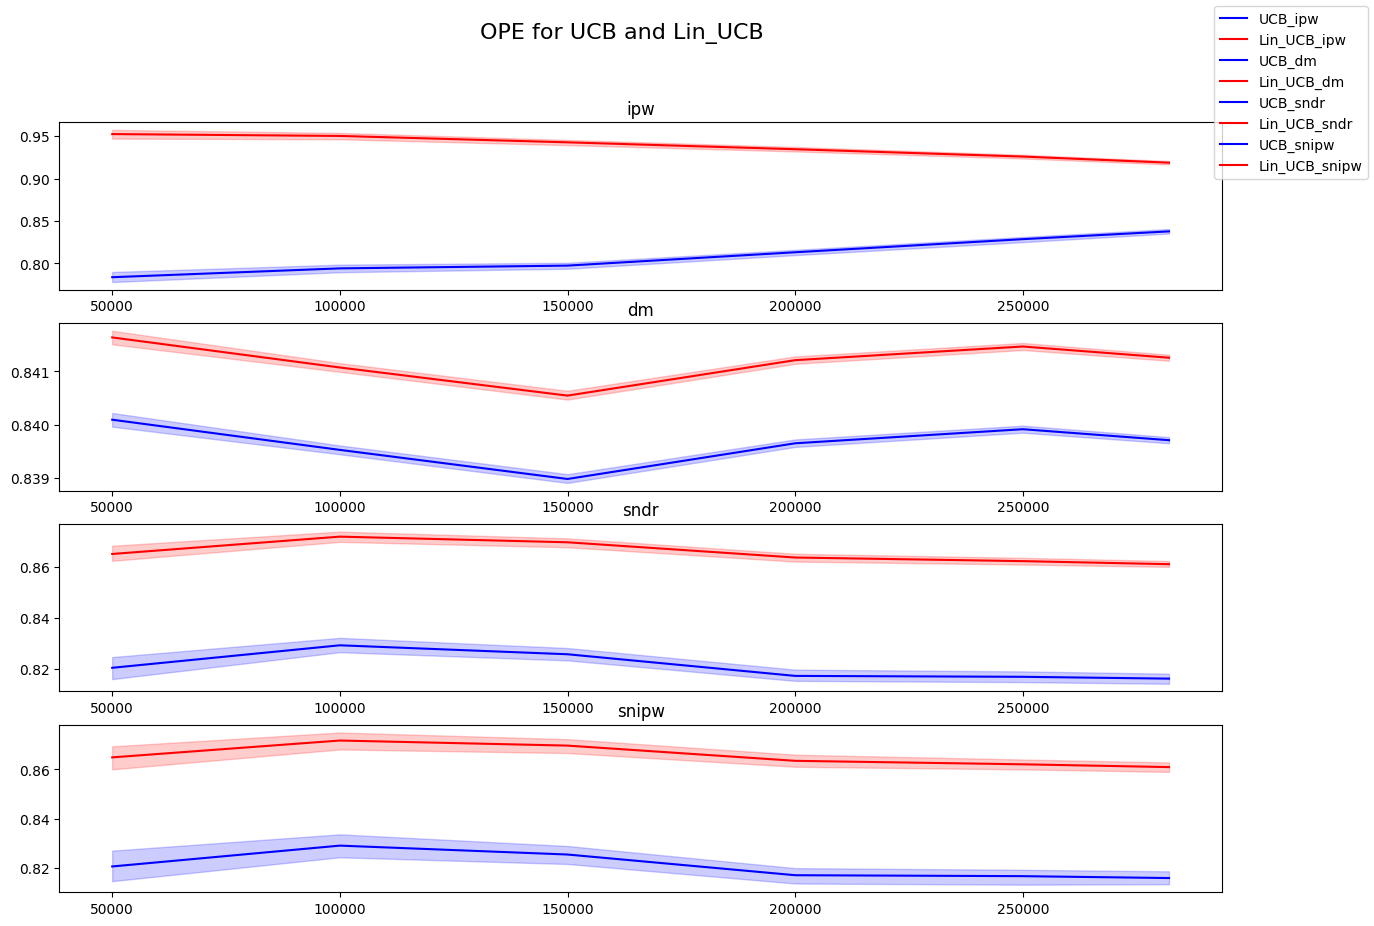

In [60]:
plot_res_two_politics(CIs_1, CIs_2, "UCB", "Lin_UCB")

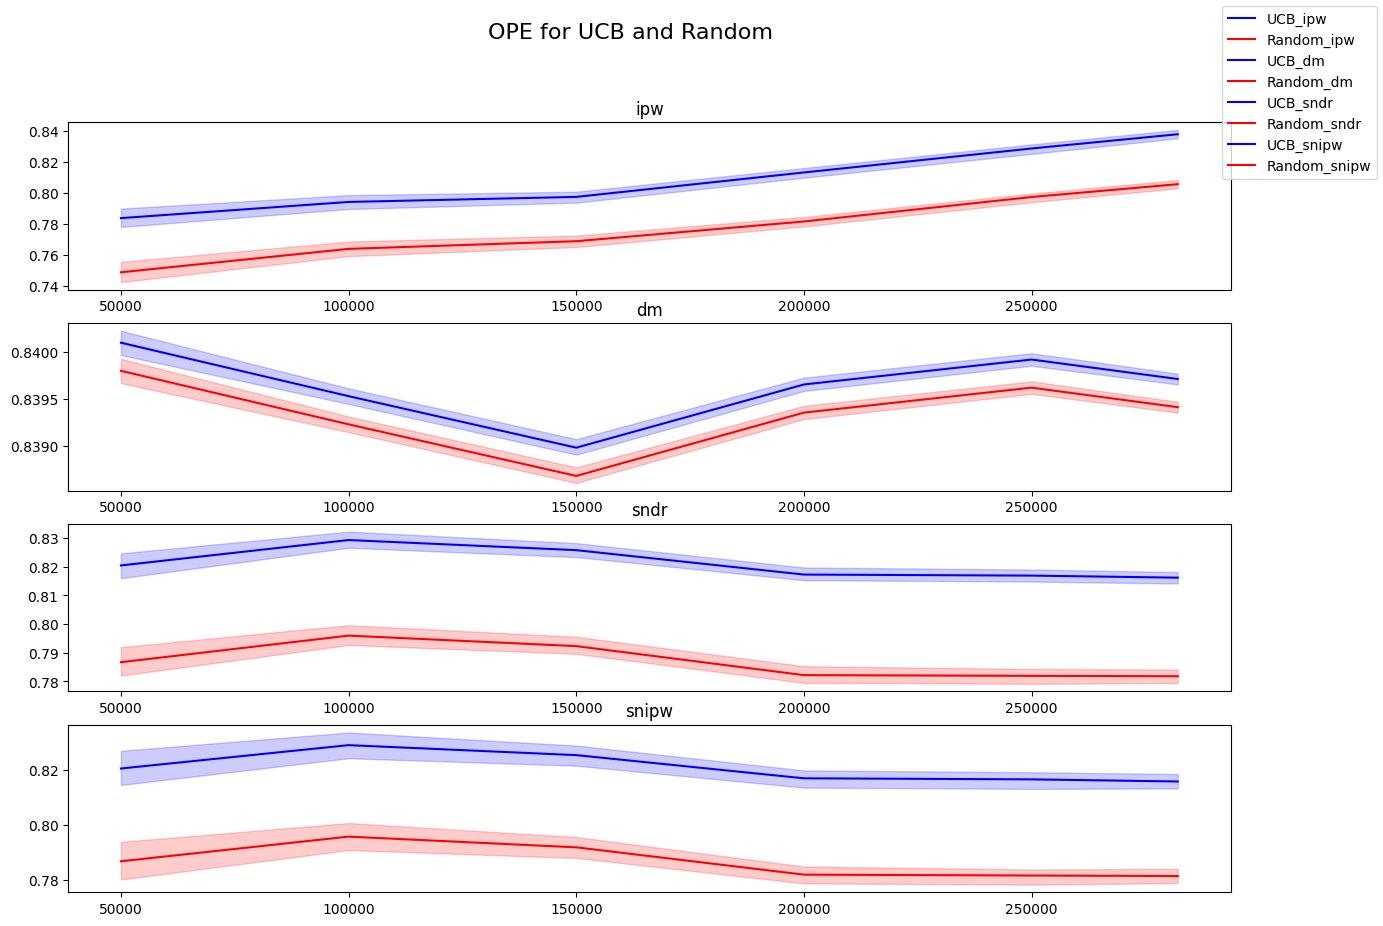

In [61]:
plot_res_two_politics(CIs_1, CIs_3, "UCB", "Random")

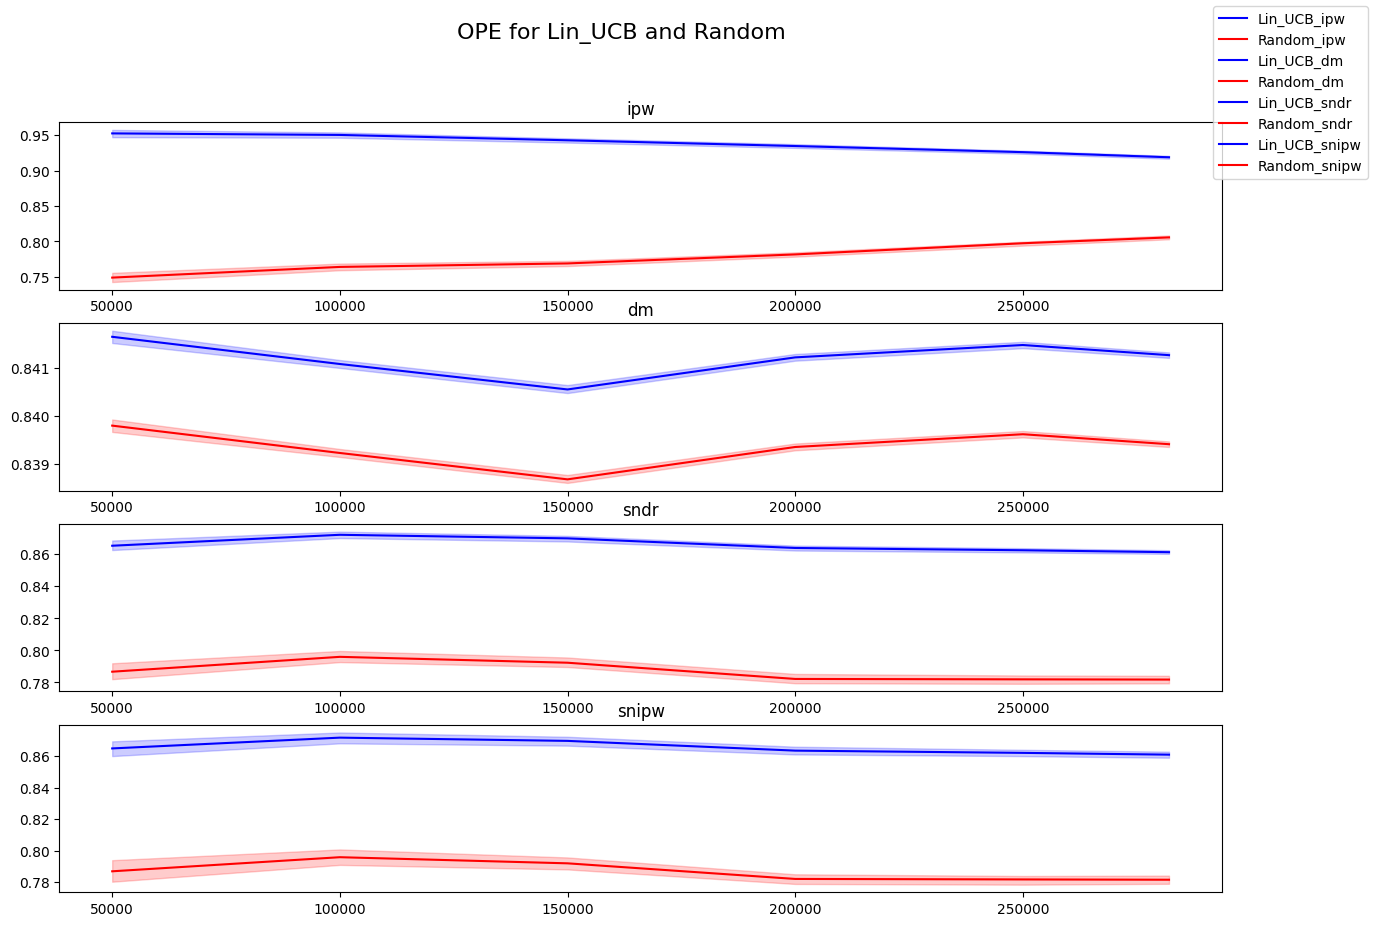

In [62]:
plot_res_two_politics(CIs_2, CIs_3, "Lin_UCB", "Random")

In [63]:
def plot_join_res(Vs, CIs, model):
    fig, ax = plt.subplots(figsize=(10, 10))
    # x = [5000, 10000, 15000, 20000, 25000, 30000]
    x = [50000, 100000, 150000, 200000, 250000, bandit_feedback_test["n_rounds"]]
    # x = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, bandit_feedback_test["n_rounds"]]
    colors = ['b', 'r', 'g', 'y', 'k']
    i = 0
    for name in ['ipw','dm', 'sndr', 'snipw']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax.plot(x, y_est, '-', label=name, color = colors[i])
        ax.fill_between(x, y_low, y_up, alpha=0.2, color = colors[i])
        #ax.plot(x, y, 'o', color='tab:brown')
        i=i+1
    fig.suptitle("OPE for " + model, fontsize=16)
    fig.legend()

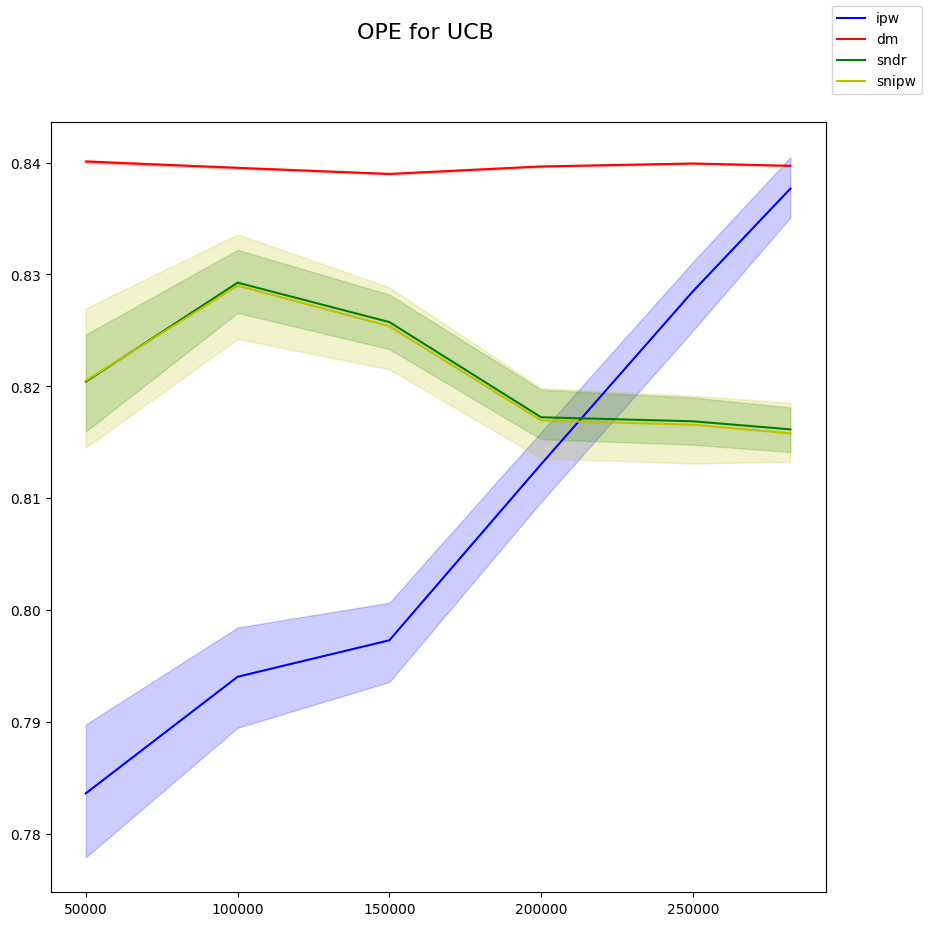

In [64]:
plot_join_res(Vs_1, CIs_1, 'UCB')

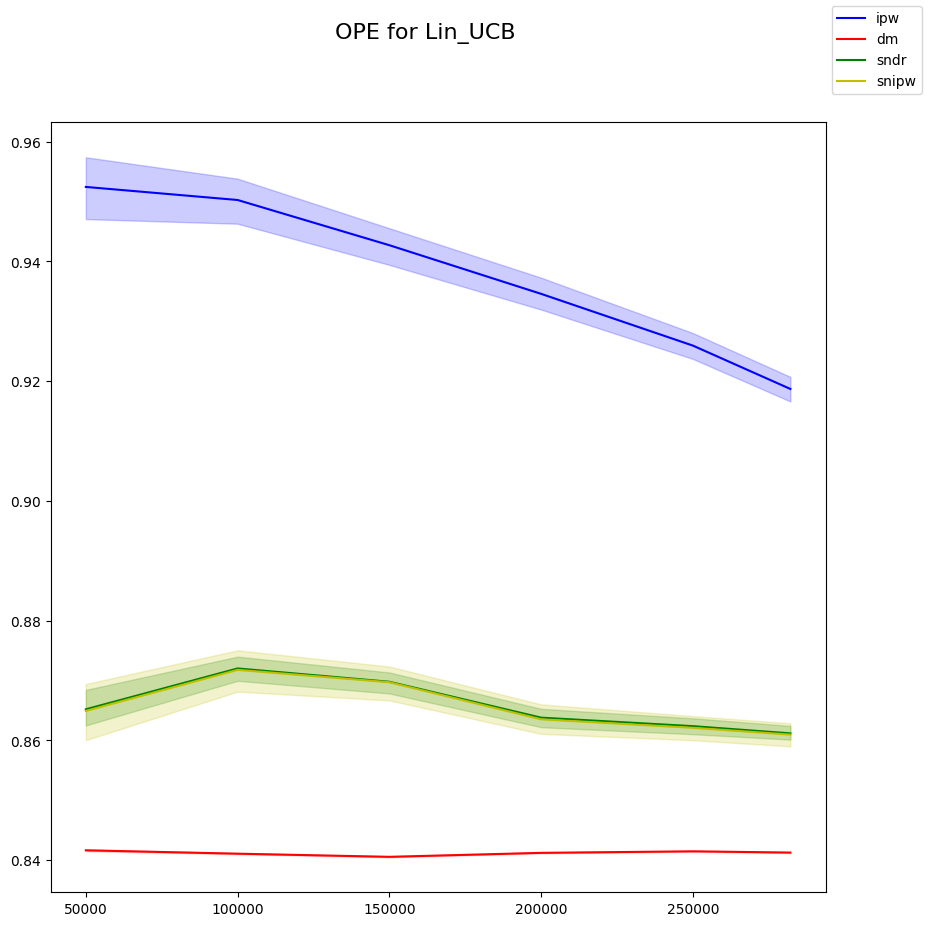

In [65]:
plot_join_res(Vs_2, CIs_2, 'Lin_UCB')

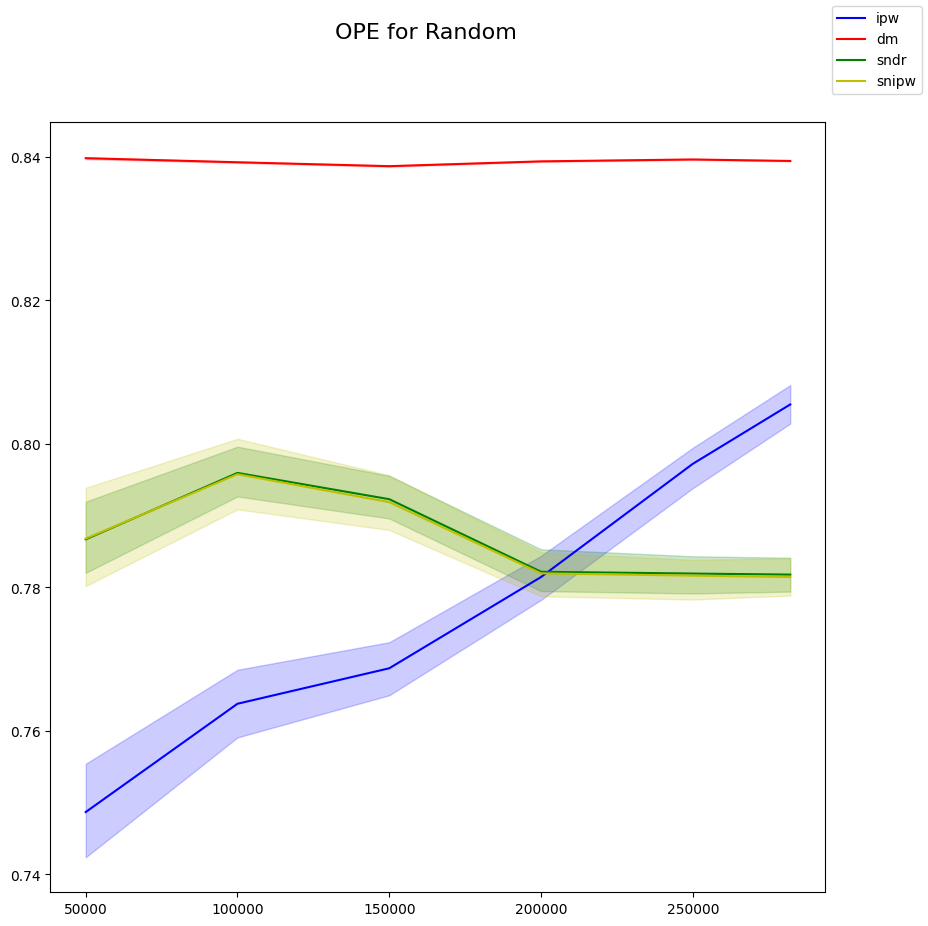

In [66]:
plot_join_res(Vs_3, CIs_3, 'Random')

# Metrics evaluation

In [31]:
import warnings
warnings.filterwarnings("ignore")

In [32]:
len(bandit_feedback_test['log'].toPandas()['user_idx'].unique()), len(data.ratings['user_id'].unique())

(2304, 6040)

In [40]:
print("Ucb")
print(learner_1.predict_and_evaluate(bandit_feedback_test, 1))
print(learner_1.predict_and_evaluate(bandit_feedback_test, 3))
print(learner_1.predict_and_evaluate(bandit_feedback_test, 10))

Ucb


100%|██████████| 229/229 [00:56<00:00,  4.05it/s]                               


{'hr@1': 0.01225382932166302, 'mrr@1': 0.01225382932166302, 'ndcg@1': 0.01225382932166302, 'cov@1': 0.002}


100%|██████████| 229/229 [00:55<00:00,  4.12it/s]


{'hr@3': 0.04113785557986871, 'mrr@3': 0.02472647702407002, 'ndcg@3': 0.014862502892629607, 'cov@3': 0.0055}


100%|██████████| 229/229 [00:55<00:00,  4.12it/s]


{'hr@10': 0.14573304157549233, 'mrr@10': 0.042139383835226286, 'ndcg@10': 0.020206489462517418, 'cov@10': 0.014}


In [41]:
print("Ucb")
print(learner_1.predict_and_evaluate_new(bandit_feedback_test, 1))
print(learner_1.predict_and_evaluate_new(bandit_feedback_test, 3))
print(learner_1.predict_and_evaluate_new(bandit_feedback_test, 10))

Ucb


100%|██████████| 229/229 [00:55<00:00,  4.15it/s]


{'hr@1': 0.0001339014620903784, 'mrr@1': 0.0001339014620903784, 'ndcg@1': 0.0001339014620903784, 'cov@1': 0.0025}


100%|██████████| 229/229 [00:55<00:00,  4.14it/s]


{'hr@3': 0.0005028243492486367, 'mrr@3': 0.000294263984360111, 'ndcg@3': 0.00034773429340174554, 'cov@3': 0.0065}


100%|██████████| 229/229 [00:55<00:00,  4.13it/s]


{'hr@10': 0.0022524267254492186, 'mrr@10': 0.0005807113781615191, 'ndcg@10': 0.0009624420912411778, 'cov@10': 0.0205}


In [42]:
print("Lin_ucb")
print(learner_2.predict_and_evaluate(bandit_feedback_test, 1))
print(learner_2.predict_and_evaluate(bandit_feedback_test, 3))
print(learner_2.predict_and_evaluate(bandit_feedback_test, 10))

Lin_ucb


100%|██████████| 229/229 [00:28<00:00,  8.08it/s]                               


{'hr@1': 0.44682713347921227, 'mrr@1': 0.44682713347921227, 'ndcg@1': 0.44682713347921227, 'cov@1': 0.0245}


100%|██████████| 229/229 [00:26<00:00,  8.66it/s]


{'hr@3': 0.6560175054704596, 'mrr@3': 0.5398249452954048, 'ndcg@3': 0.41568419255701816, 'cov@3': 0.041}


100%|██████████| 229/229 [00:26<00:00,  8.80it/s]


{'hr@10': 0.8218818380743983, 'mrr@10': 0.5705229064638254, 'ndcg@10': 0.3794879181691045, 'cov@10': 0.0915}


In [43]:
print("Lin_ucb")
print(learner_2.predict_and_evaluate_new(bandit_feedback_test, 1))
print(learner_2.predict_and_evaluate_new(bandit_feedback_test, 3))
print(learner_2.predict_and_evaluate_new(bandit_feedback_test, 10))

Lin_ucb


100%|██████████| 229/229 [00:26<00:00,  8.55it/s]


{'hr@1': 0.009942473372064204, 'mrr@1': 0.009942473372064204, 'ndcg@1': 0.009942473372064204, 'cov@1': 0.037}


100%|██████████| 229/229 [00:25<00:00,  8.83it/s]


{'hr@3': 0.02555735847889485, 'mrr@3': 0.01666856841276248, 'ndcg@3': 0.01894488560437258, 'cov@3': 0.069}


100%|██████████| 229/229 [00:25<00:00,  8.85it/s]


{'hr@10': 0.06356286272498078, 'mrr@10': 0.022778575206101475, 'ndcg@10': 0.03219894065131111, 'cov@10': 0.1385}


In [40]:
print("Random")
print(learner_3.predict_and_evaluate(bandit_feedback_test, 1))
print(learner_3.predict_and_evaluate(bandit_feedback_test, 3))
print(learner_3.predict_and_evaluate(bandit_feedback_test, 10))

Random


100%|██████████| 229/229 [00:56<00:00,  4.02it/s]                               


{'hr@1': 0.05470459518599562, 'mrr@1': 0.05470459518599562, 'ndcg@1': 0.05470459518599562, 'cov@1': 0.669}


100%|██████████| 229/229 [00:55<00:00,  4.13it/s]


{'hr@3': 0.1387308533916849, 'mrr@3': 0.08993435448577679, 'ndcg@3': 0.0523281847546252, 'cov@3': 0.972}


100%|██████████| 229/229 [00:55<00:00,  4.12it/s]


{'hr@10': 0.3588621444201313, 'mrr@10': 0.12642544545170367, 'ndcg@10': 0.055315405043797373, 'cov@10': 1.0}


In [41]:
print("Random")
print(learner_3.predict_and_evaluate_new(bandit_feedback_test, 1))
print(learner_3.predict_and_evaluate_new(bandit_feedback_test, 3))
print(learner_3.predict_and_evaluate_new(bandit_feedback_test, 10))

Random


100%|██████████| 229/229 [00:55<00:00,  4.15it/s]


{'hr@1': 0.0005846729048953394, 'mrr@1': 0.0005846729048953394, 'ndcg@1': 0.0005846729048953394, 'cov@1': 0.688}


100%|██████████| 229/229 [00:55<00:00,  4.14it/s]


{'hr@3': 0.0015867832401430517, 'mrr@3': 0.0009933678951347938, 'ndcg@3': 0.0011443779601760541, 'cov@3': 0.977}


100%|██████████| 229/229 [00:54<00:00,  4.18it/s]


{'hr@10': 0.0061080755220244915, 'mrr@10': 0.001732333826774071, 'ndcg@10': 0.0027314965935941, 'cov@10': 1.0}


In [47]:
print("Lin_ucb_n")
print(learner_2.predict_and_evaluate(bandit_feedback_test, 1))
print(learner_2.predict_and_evaluate(bandit_feedback_test, 3))
print(learner_2.predict_and_evaluate(bandit_feedback_test, 10))

Lin_ucb_n


100%|██████████| 229/229 [00:29<00:00,  7.85it/s]


{'hr@1': 0.44814004376367617, 'mrr@1': 0.44814004376367617, 'ndcg@1': 0.44814004376367617, 'cov@1': 0.0205}


100%|██████████| 229/229 [00:26<00:00,  8.54it/s]


{'hr@3': 0.6542669584245077, 'mrr@3': 0.5416484318016046, 'ndcg@3': 0.41461582115024, 'cov@3': 0.039}


100%|██████████| 229/229 [00:26<00:00,  8.55it/s]


{'hr@10': 0.8175054704595186, 'mrr@10': 0.5714923066235976, 'ndcg@10': 0.3768422644822775, 'cov@10': 0.0905}


In [48]:
print("Lin_ucb_n")
print(learner_2.predict_and_evaluate_new(bandit_feedback_test, 1))
print(learner_2.predict_and_evaluate_new(bandit_feedback_test, 3))
print(learner_2.predict_and_evaluate_new(bandit_feedback_test, 10))

Lin_ucb_n


100%|██████████| 229/229 [00:26<00:00,  8.65it/s]


{'hr@1': 0.011108932784688278, 'mrr@1': 0.011108932784688278, 'ndcg@1': 0.011108932784688278, 'cov@1': 0.036}


100%|██████████| 229/229 [00:25<00:00,  8.93it/s]


{'hr@3': 0.02475595533640254, 'mrr@3': 0.01695348180813966, 'ndcg@3': 0.018950193641446022, 'cov@3': 0.063}


100%|██████████| 229/229 [00:25<00:00,  8.94it/s]


{'hr@10': 0.0622072076455509, 'mrr@10': 0.022926388017016824, 'ndcg@10': 0.031964015236304266, 'cov@10': 0.126}


In [42]:
print("Ucb")
print(learner_1.predict_and_evaluate(bandit_feedback_test, 1))

print("Lin_ucb")
print(learner_2.predict_and_evaluate(bandit_feedback_test, 1))

print("Random")
print(learner_3.predict_and_evaluate(bandit_feedback_test, 1))

print("TS")
print(learner_4.predict_and_evaluate(bandit_feedback_test, 1))

Ucb


100%|██████████| 233/233 [00:41<00:00,  5.61it/s]


{'hr@1': 0.4670400689358035, 'mrr@1': 0.4670400689358035, 'ndcg@1': 0.4670400689358035, 'cov@1': 0.15666666666666668}
Lin_ucb


100%|██████████| 233/233 [00:19<00:00, 11.99it/s]


{'hr@1': 0.4635932787591555, 'mrr@1': 0.4635932787591555, 'ndcg@1': 0.4635932787591555, 'cov@1': 0.17333333333333334}
Random


100%|██████████| 233/233 [00:40<00:00,  5.77it/s]


{'hr@1': 0.16975441619991383, 'mrr@1': 0.16975441619991383, 'ndcg@1': 0.16975441619991383, 'cov@1': 1.0}
TS


100%|██████████| 233/233 [00:42<00:00,  5.42it/s]

{'hr@1': 0.4670400689358035, 'mrr@1': 0.4670400689358035, 'ndcg@1': 0.4670400689358035, 'cov@1': 0.15666666666666668}


In [43]:
print("Ucb")
print(learner_1.predict_and_evaluate(bandit_feedback_test, 3))

print("Lin_ucb")
print(learner_2.predict_and_evaluate(bandit_feedback_test, 3))

print("Random")
print(learner_3.predict_and_evaluate(bandit_feedback_test, 3))

print("TS")
print(learner_4.predict_and_evaluate(bandit_feedback_test, 3))

Ucb


100%|██████████| 233/233 [00:40<00:00,  5.76it/s]


{'hr@3': 0.6691081430417923, 'mrr@3': 0.5593853224184977, 'ndcg@3': 0.42623738641492426, 'cov@3': 0.32}
Lin_ucb


100%|██████████| 233/233 [00:19<00:00, 12.17it/s]


{'hr@3': 0.6734166307626023, 'mrr@3': 0.557733735458854, 'ndcg@3': 0.4250842998115051, 'cov@3': 0.36}
Random


100%|██████████| 233/233 [00:40<00:00,  5.82it/s]


{'hr@3': 0.36665230504093066, 'mrr@3': 0.25448800804251037, 'ndcg@3': 0.16937171661658873, 'cov@3': 1.0}
TS


100%|██████████| 233/233 [00:42<00:00,  5.45it/s]

{'hr@3': 0.6691081430417923, 'mrr@3': 0.5593853224184977, 'ndcg@3': 0.42603519825205366, 'cov@3': 0.31333333333333335}


In [44]:
print("Ucb")
print(learner_1.predict_and_evaluate(bandit_feedback_test, 10))

print("Lin_ucb")
print(learner_2.predict_and_evaluate(bandit_feedback_test, 10))

print("Random")
print(learner_3.predict_and_evaluate(bandit_feedback_test, 10))

print("TS")
print(learner_4.predict_and_evaluate(bandit_feedback_test, 10))

Ucb


100%|██████████| 233/233 [00:40<00:00,  5.79it/s]


{'hr@10': 0.8272296423955192, 'mrr@10': 0.5879740191351566, 'ndcg@10': 0.38112698318466653, 'cov@10': 0.68}
Lin_ucb


100%|██████████| 233/233 [00:19<00:00, 12.17it/s]


{'hr@10': 0.8358466178371392, 'mrr@10': 0.5867667877146551, 'ndcg@10': 0.3856533089891888, 'cov@10': 0.76}
Random


100%|██████████| 233/233 [00:39<00:00,  5.86it/s]


{'hr@10': 0.6484274019819044, 'mrr@10': 0.30237565225716884, 'ndcg@10': 0.17028315188375556, 'cov@10': 1.0}
TS


100%|██████████| 233/233 [00:42<00:00,  5.49it/s]

{'hr@10': 0.8259370960792761, 'mrr@10': 0.5877028579635215, 'ndcg@10': 0.3812850139415, 'cov@10': 0.6766666666666666}


In [45]:
print("Ucb")
print(learner_1.predict_and_evaluate_new(bandit_feedback_test, 1))

print("Lin_ucb")
print(learner_2.predict_and_evaluate_new(bandit_feedback_test, 1))

print("Random")
print(learner_3.predict_and_evaluate_new(bandit_feedback_test, 1))

print("TS")
print(learner_4.predict_and_evaluate_new(bandit_feedback_test, 1))

Ucb


100%|██████████| 233/233 [00:40<00:00,  5.81it/s]


{'hr@1': 0.020682141249444126, 'mrr@1': 0.020682141249444126, 'ndcg@1': 0.020682141249444126, 'cov@1': 0.25}
Lin_ucb


100%|██████████| 233/233 [00:19<00:00, 12.17it/s]


{'hr@1': 0.019958585255325147, 'mrr@1': 0.019958585255325147, 'ndcg@1': 0.019958585255325147, 'cov@1': 0.27}
Random


100%|██████████| 233/233 [00:39<00:00,  5.87it/s]


{'hr@1': 0.0043709069575707474, 'mrr@1': 0.0043709069575707474, 'ndcg@1': 0.0043709069575707474, 'cov@1': 1.0}
TS


100%|██████████| 233/233 [00:42<00:00,  5.48it/s]


{'hr@1': 0.020687658417850925, 'mrr@1': 0.020687658417850925, 'ndcg@1': 0.020687658417850925, 'cov@1': 0.25333333333333335}


In [46]:
print("Ucb")
print(learner_1.predict_and_evaluate_new(bandit_feedback_test, 3))

print("Lin_ucb")
print(learner_2.predict_and_evaluate_new(bandit_feedback_test, 3))

print("Random")
print(learner_3.predict_and_evaluate_new(bandit_feedback_test, 3))

print("TS")
print(learner_4.predict_and_evaluate_new(bandit_feedback_test, 3))

Ucb


 18%|█▊        | 43/233 [00:07<00:33,  5.75it/s]

100%|██████████| 233/233 [00:40<00:00,  5.80it/s]


{'hr@3': 0.04723949705491287, 'mrr@3': 0.03213922261349987, 'ndcg@3': 0.03600696008780316, 'cov@3': 0.41333333333333333}
Lin_ucb


100%|██████████| 233/233 [00:19<00:00, 12.16it/s]


{'hr@3': 0.046275618509300086, 'mrr@3': 0.03101021418906793, 'ndcg@3': 0.034907658842111826, 'cov@3': 0.49}
Random


100%|██████████| 233/233 [00:39<00:00,  5.87it/s]


{'hr@3': 0.013633635997973178, 'mrr@3': 0.0082072626841534, 'ndcg@3': 0.009590496475817317, 'cov@3': 1.0}
TS


100%|██████████| 233/233 [00:42<00:00,  5.48it/s]


{'hr@3': 0.04717611884409081, 'mrr@3': 0.03211832379208503, 'ndcg@3': 0.035975318642418666, 'cov@3': 0.4166666666666667}


In [47]:
print("Ucb")
print(learner_1.predict_and_evaluate_new(bandit_feedback_test, 10))

print("Lin_ucb")
print(learner_2.predict_and_evaluate_new(bandit_feedback_test, 10))

print("Random")
print(learner_3.predict_and_evaluate_new(bandit_feedback_test, 10))

print("TS")
print(learner_4.predict_and_evaluate_new(bandit_feedback_test, 10))

Ucb


100%|██████████| 233/233 [00:40<00:00,  5.78it/s]


{'hr@10': 0.11779749136119258, 'mrr@10': 0.0431832143547206, 'ndcg@10': 0.06032948987767, 'cov@10': 0.7866666666666666}
Lin_ucb


100%|██████████| 233/233 [00:19<00:00, 12.15it/s]


{'hr@10': 0.1204479967073282, 'mrr@10': 0.0428501784602406, 'ndcg@10': 0.060691285061326414, 'cov@10': 0.8666666666666667}
Random


100%|██████████| 233/233 [00:39<00:00,  5.87it/s]


{'hr@10': 0.04604200880048093, 'mrr@10': 0.013301001439690215, 'ndcg@10': 0.020783585281145423, 'cov@10': 1.0}
TS


100%|██████████| 233/233 [00:42<00:00,  5.46it/s]


{'hr@10': 0.11788482726928337, 'mrr@10': 0.04317580346465341, 'ndcg@10': 0.060340854454522044, 'cov@10': 0.7933333333333333}


In [57]:
assert 1 == 0

AssertionError: 

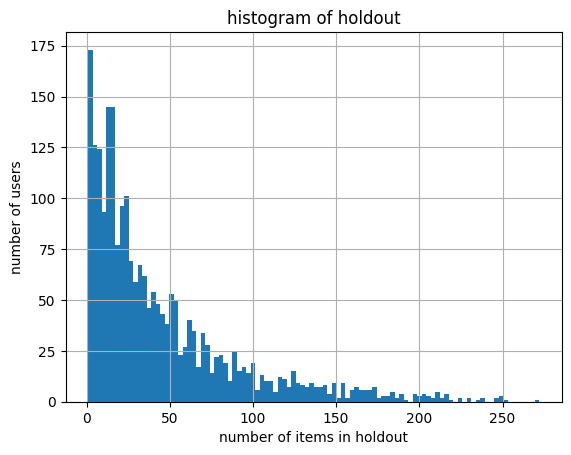

In [85]:
plt.hist(holdout_actions.sum(axis = 1), bins = 100)
plt.grid()
plt.title('histogram of holdout')
plt.xlabel('number of items in holdout')
plt.ylabel('number of users')
plt.show()

In [69]:
p1 = 1 - ((300 - holdout_actions.sum(axis = 1))/300)**1

p3 = 1 - ((300 - holdout_actions.sum(axis = 1))/300)**3

p10 = 1 - ((300 - holdout_actions.sum(axis = 1))/300)**10

print('hr@1:', np.mean(p1), 'hr@2:',np.mean(p3), 'hr@3:',np.mean(p10))

hr@1: 0.1515539279046388 hr@2: 0.3337076625815821 hr@3: 0.6060468370009982
